# Seoul Bike Sharing Demand Analysis

**Group 2: Xiao Hu, Vinky Wang, Izzy Zhang**

## 1. Introduction

### 1.1 Motivation

### 1.2 Dataset Description

In [1]:
# Load packages
library(tidyverse)
library(lubridate)
library(corrplot)
library(car)
library(repr)
library(broom)
library(MASS)
library(rsample)
library(DHARMa)
library(AER)
library(ggpubr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.0      ✔ stringr 1.4.0 
✔ readr   2.1.2      ✔ forcats 0.5.1 

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


corrplot 0.92 loaded

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


This is DHARMa 0.4.6. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')

Loading required package: lmtest

Loading required package: zoo


In [2]:
# Load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv"
bike = read.csv(url,check.names=F)

## 2. Methods and Results

### 2.1 Exploratory Data Analysis

#### 2.1.1 Data Cleaning

In [3]:
# Rename columns
colnames(bike) <- c("date", "count", "hour", "temp", "humidity", "windspeed", "visibility", "dew", "solar", "rain", "snow", "seasons", "holiday", "functioning")

# Convert variable into different classes
bike <- bike %>%
  mutate(date = as.POSIXct(date, format = "%d/%m/%Y"), # date
         month =  factor(months(date)),      # add months variable
         seasons = factor(seasons), # factor
         holiday = factor(holiday), # factor
         functioning = factor(functioning)) # factor

We noticed that count becomes zero when `functioning == "No"`. So we proceeded with removing all rows when the bike sharing system is not functioning and the `functioning` column. 

In [4]:
## remove functioning == "No" rows from the dataset. 
bike <- bike[which(bike$functioning == "Yes"),]
bike <- subset(bike, select = -functioning)

In [5]:
bike$month <- relevel(bike$month, ref = "January")
bike$holiday <- relevel(bike$holiday,ref = "No Holiday")

We are also removing the `date` column since we do not plan to do time series analysis. 

In [6]:
bike <- subset(bike, select = -date)
head(bike)

,count,hour,temp,humidity,windspeed,visibility,dew,solar,rain,snow,seasons,holiday,month
,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,254,0,-5.2,37,2.2,2000,-17.6,0,0,0,Winter,No Holiday,December
2,204,1,-5.5,38,0.8,2000,-17.6,0,0,0,Winter,No Holiday,December
3,173,2,-6.0,39,1.0,2000,-17.7,0,0,0,Winter,No Holiday,December
4,107,3,-6.2,40,0.9,2000,-17.6,0,0,0,Winter,No Holiday,December
5,78,4,-6.0,36,2.3,2000,-18.6,0,0,0,Winter,No Holiday,December
6,100,5,-6.4,37,1.5,2000,-18.7,0,0,0,Winter,No Holiday,December


After cleaning the data, we split the dataframe into training and testing for further analyses. We chose a proportion of 70/30. 

In [7]:
set.seed(34567)
bike_split <- initial_split(bike, prop = 0.7)
bike_training <- training(bike_split)
bike_testing <- testing(bike_split)

#### 2.1.2 Multi-collinearity
We have tested for multi-collinearity in the whole dataset in our proposal. Now we will identify variables in the training set that are correlated with one another and select a subset of the dataset that minimizes multicollinearity. 

,temp,humidity,windspeed,visibility,dew,solar,rain,snow
temp,1.00000000,0.1539553,-0.03197670,0.03636107,0.9136303,0.36161865,0.05607276,-0.21245692
humidity,0.15395525,1.0000000,-0.33148340,-0.55201175,0.5296681,-0.45802066,0.24539100,0.10985523
windspeed,-0.03197670,-0.3314834,1.00000000,0.18717004,-0.1696710,0.32598825,-0.03217295,-0.01145729
visibility,0.03636107,-0.5520118,0.18717004,1.00000000,-0.1778320,0.16187554,-0.17153928,-0.12838257
dew,0.91363031,0.5296681,-0.16967095,-0.17783202,1.0000000,0.10404535,0.13379372,-0.14603775
solar,0.36161865,-0.4580207,0.32598825,0.16187554,0.1040453,1.00000000,-0.07705423,-0.07186494
rain,0.05607276,0.2453910,-0.03217295,-0.17153928,0.1337937,-0.07705423,1.00000000,0.01653452
snow,-0.21245692,0.1098552,-0.01145729,-0.12838257,-0.1460377,-0.07186494,0.01653452,1.00000000


Warning message in text.default(pos.xlabel[, 1], pos.xlabel[, 2], newcolnames, srt = tl.srt, :
“"use" is not a graphical parameter”
Warning message in text.default(pos.ylabel[, 1], pos.ylabel[, 2], newrownames, col = tl.col, :
“"use" is not a graphical parameter”
Warning message in title(title, ...):
“"use" is not a graphical parameter”


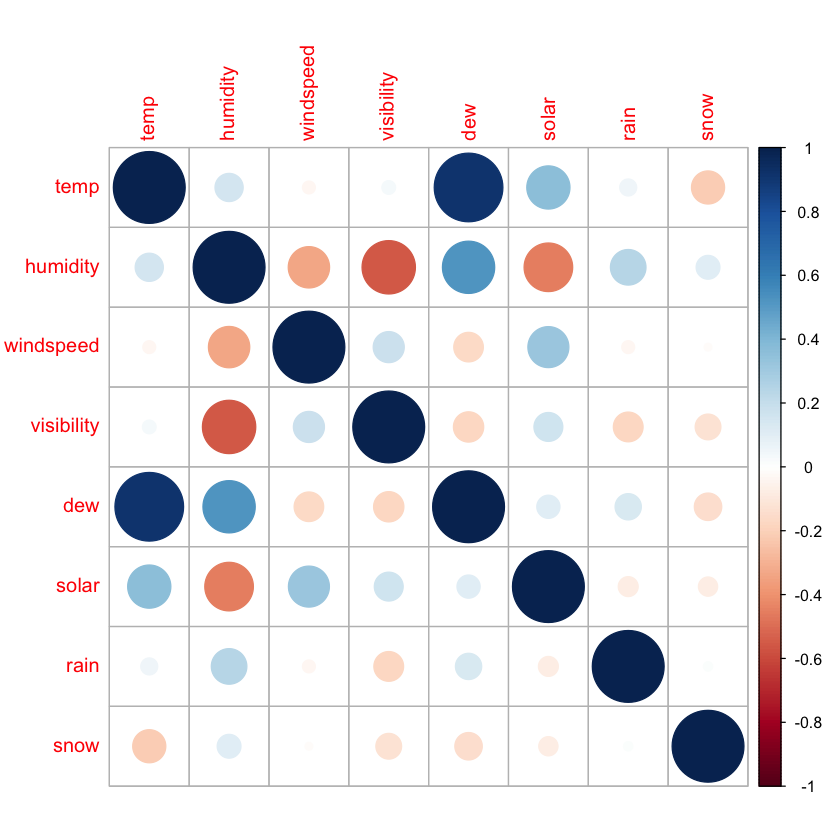

In [8]:
# Select only numeric environmental variables
bike_var <- bike_training %>%
  dplyr::select(c(temp, humidity, windspeed, visibility, dew, solar, rain, snow))

# Correlation matrix
cor_matrix <- cor(bike_var)
cor_matrix

# Correlation plot
corrplot(cor_matrix, use = "complete.obs", method="circle")

We see from the correlation plot a strong positive correlation between `dew` and `temp`, a relatively strong positive correlation between `dew` and `humidity`, a strong negative correlation between `visibility` and `humidity`, and a relatively strong negative correlation between `solar` and `humidity`. 

We proceed to test the observations above using variance inflation factors (VIF). 

In [9]:
# Variance inflation factor selection with all numerical variables
model_vif1 <- glm(count~ temp + humidity + windspeed + visibility + dew + solar + rain + snow, data = bike_training,family = poisson)
vif(model_vif1)

temp   humidity  windspeed visibility        dew      solar       rain 
 47.711475  11.736937   1.184112   1.382702  59.455206   1.960071   1.057594 
      snow 
  1.040290

We see that `temp`, `humidity` and `dew` have VIFs larger than 5, suggesting high correlation with other variables. We start by removing `dew`, which has the highest VIF. 

In [10]:
## remove dew variable
model_vif2 <- glm(count~ temp + humidity + windspeed + visibility + solar + rain + snow, data = bike_training,family = poisson)
vif(model_vif2)

temp   humidity  windspeed visibility      solar       rain       snow 
  1.429081   2.007410   1.180126   1.380984   1.854448   1.050448   1.040015

All VIFs are now lower than 5. We can then remove `dew` from our testing set and continue with model fitting. 

In [11]:
bike_training <- subset(bike_training, select = -dew)
head(bike_training)

,count,hour,temp,humidity,windspeed,visibility,solar,rain,snow,seasons,holiday,month
,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1459,100,18,-2.3,91,0.4,202,0.00,1.4,2.0,Winter,No Holiday,January
596,184,19,-1.8,41,2.1,2000,0.00,0.0,0.0,Winter,Holiday,December
1330,187,9,-16.2,33,2.9,2000,0.19,0.0,0.6,Winter,No Holiday,January
8695,287,6,2.6,33,1.5,1185,0.00,0.0,0.0,Autumn,No Holiday,November
7441,1049,0,16.3,86,0.3,2000,0.00,0.0,0.0,Autumn,No Holiday,October
1729,112,0,-6.9,36,2.1,2000,0.00,0.0,0.0,Winter,No Holiday,February


### 2.2 Model Selection

#### Poisson Regression

Since the response variable of bike rentals correspond to count data, we will first fit a full Poisson model with all variables in the data and evaluate its performance. 

$$
P(Y_i = y_i, \lambda_i, \theta) = \frac{\lambda_i^{y_i}}{y_i!} e^{-\lambda_i}  \quad \text{for} \  y_i \in \{0, 1, \cdots \}$$

Then:

$$E[Y_i]= \lambda_i$$

and 

$$V[Y_i] = \lambda_i$$

Let's explore the distribution of bike rentals. 

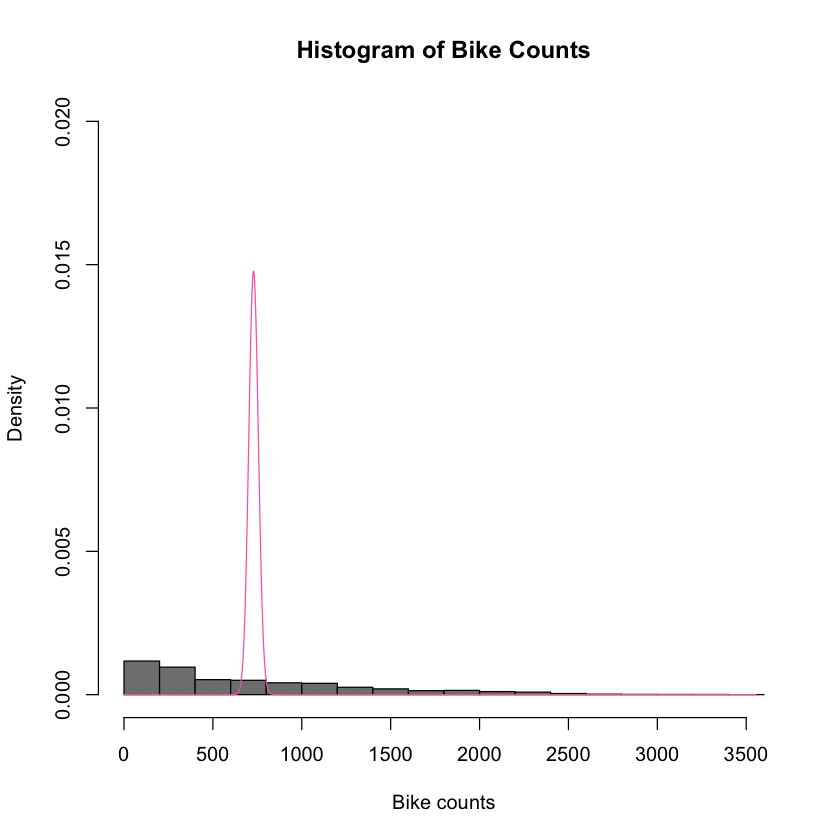

In [12]:
hist(bike$count, freq=FALSE, col=grey(0.5), ylim=c(0, 0.02), main="Histogram of Bike Counts", xlab="Bike counts")
  lines(0:max(bike$count), dpois(0:max(bike$count), mean(bike$count)), col="hotpink")

It appears that the pink line corresponding to a Poisson density with mean equal to that of the observed bike counts places more probability mass around 750 bike rentals whereas most of the actual observed bike counts are around 250 and under. This may be an early indication that the Poisson distribution is not appropriate for the dataset. 

We will proceed to fitting a Poisson distribution and check for further indications. 

In [13]:
poisson_model <- glm(formula = count~hour + temp + humidity + windspeed + visibility + solar + snow + seasons + holiday+month,
                     family = "poisson",
                     data = bike_training)
tidy(poisson_model)
glance(poisson_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),6.163587281,6.122998e-03,1006.628991,0.000000e+00
hour,0.042050824,8.446915e-05,497.824667,0.000000e+00
temp,0.037675632,1.403405e-04,268.458710,0.000000e+00
humidity,-0.010686787,4.026528e-05,-265.409484,0.000000e+00
windspeed,0.012738001,5.386766e-04,23.646842,1.271997e-123
visibility,0.000072624,1.239150e-06,58.607922,0.000000e+00
solar,-0.088686224,6.955295e-04,-127.508934,0.000000e+00
snow,-0.118339005,2.516102e-03,-47.032668,0.000000e+00
seasonsSpring,0.052755255,2.221782e-03,23.744567,1.250338e-124


null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
3189013,5924,-595085.3,1190211,1190344,1143227,5905,5925


In [14]:
deviance(poisson_model)/poisson_model$df.residual
dispersiontest(poisson_model)

[1] 193.6032


	Overdispersion test

data:  poisson_model
z = 34.098, p-value < 2.2e-16
alternative hypothesis: true dispersion is greater than 1
sample estimates:
dispersion 
    200.87 


The `residual deviance/df` is greater than 1 which suggests overdispersion. We can also use the `dispersiontest` from the `AER` package which tests the null hypothesis of equal mean and variance (i.e. equidispersion) against the alternative hypothesis $V[Y_i] = \lambda_i + c*f(\lambda_i)$ where the constant $c<0$ corresponds to underdispersion and $c>0$ corresponds to overdispersion. Effectively, this is testing $H_0: c = 0$ versus $H_1: c \neq 0$ using the t-statistic. Since the $c$ is estimated to be 200.87 and p-value < 0.05, this suggests evidence of overdispersion.

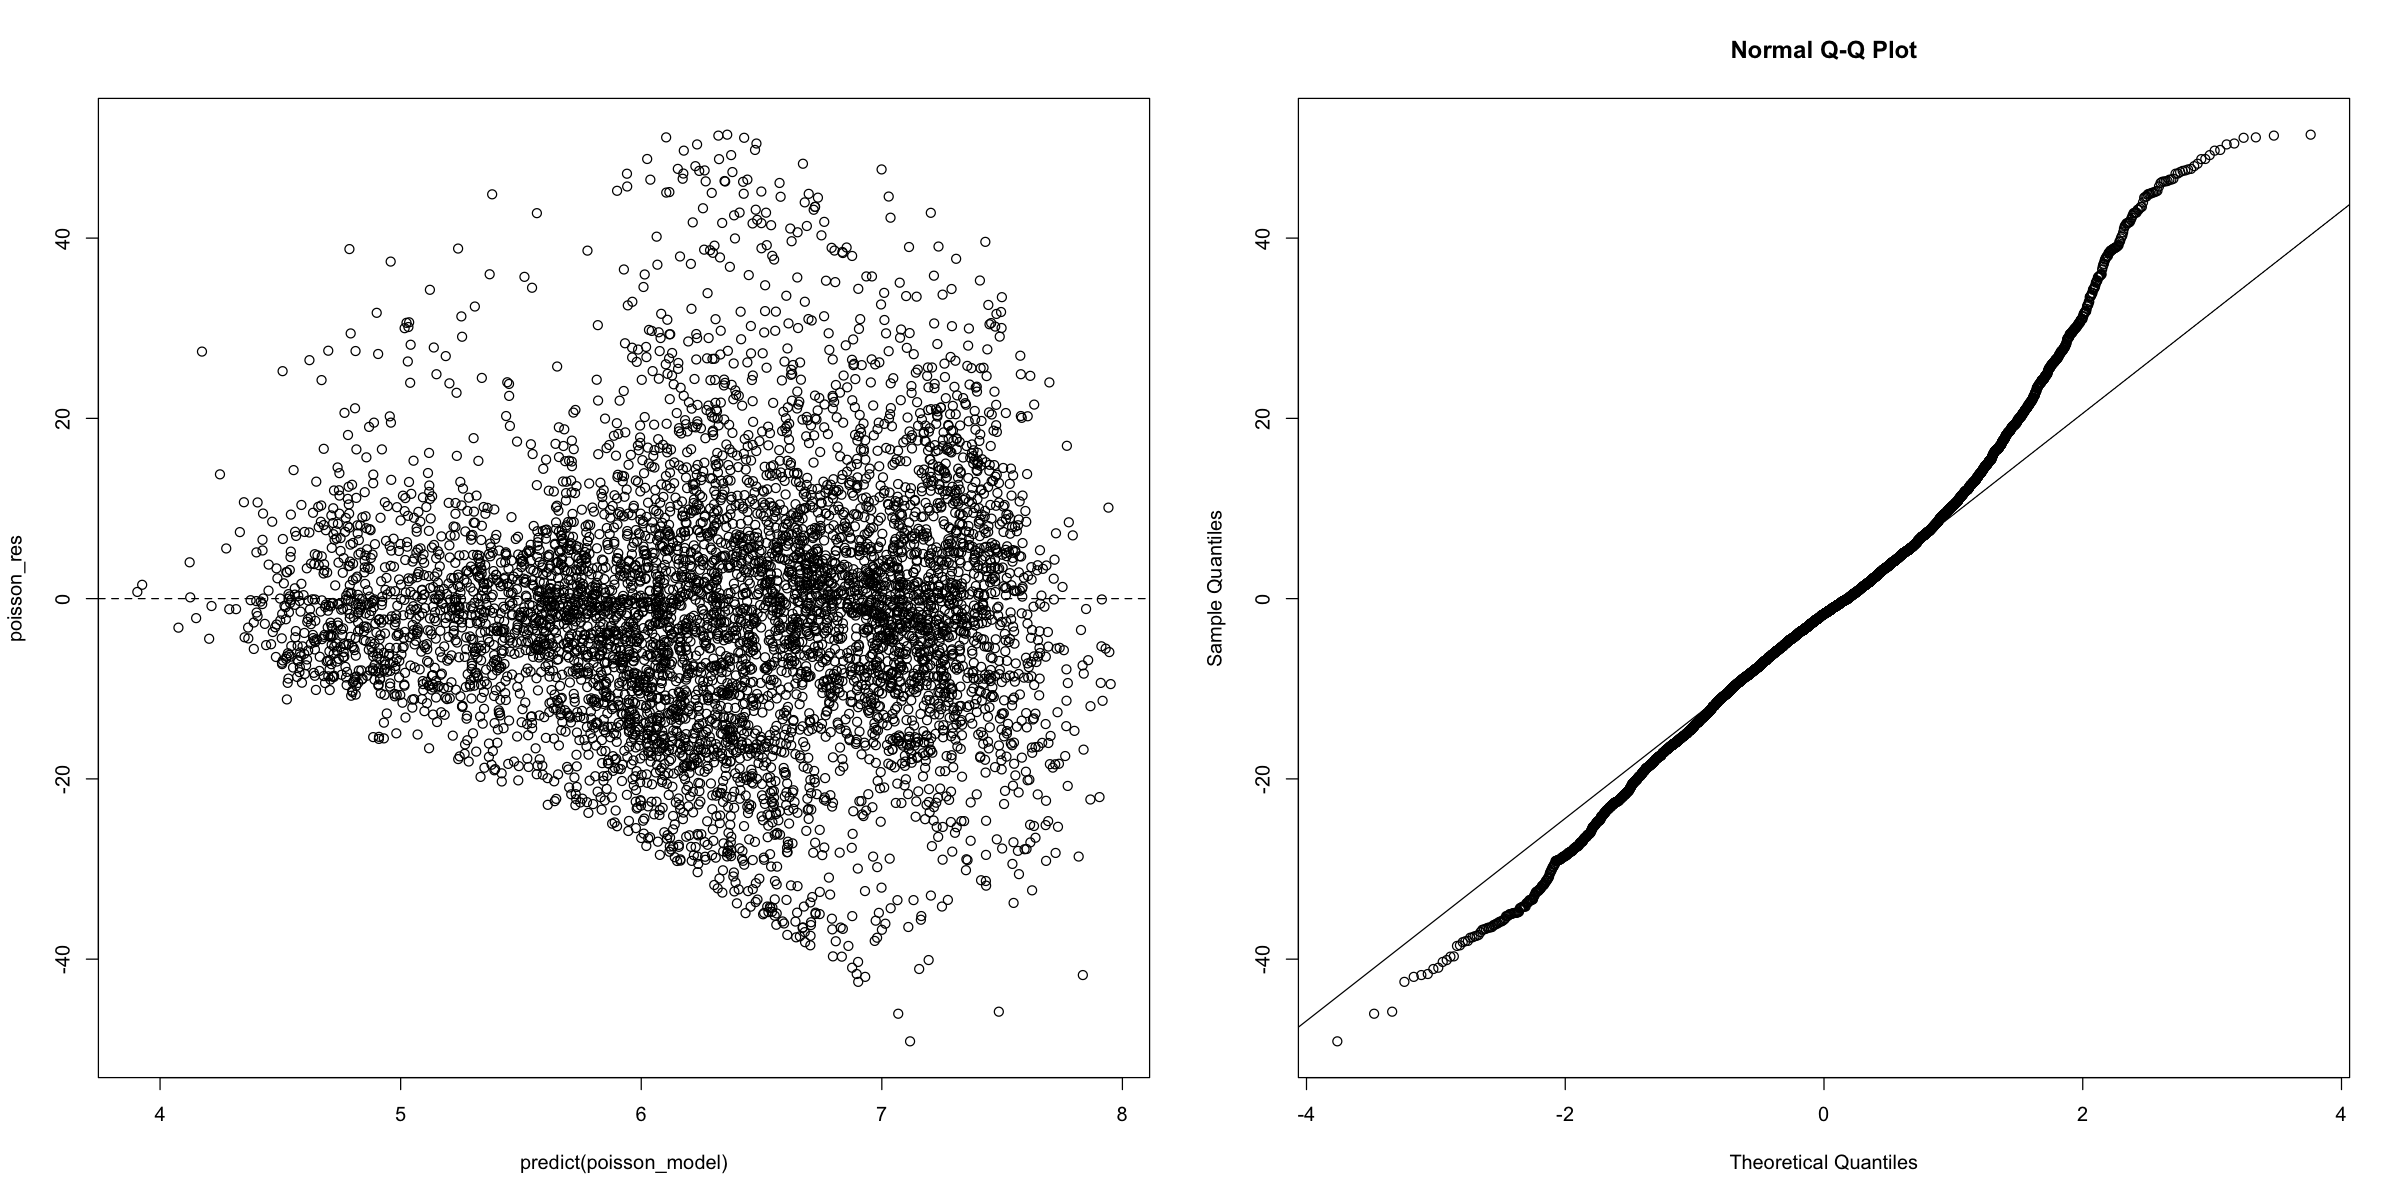

In [15]:
 # Residual plots
{options(repr.plot.width=20, repr.plot.height=10)
par(mfrow=c(1,2))
poisson_res <- residuals(poisson_model, type="deviance")
plot(predict(poisson_model), poisson_res)
abline(h=0, lty=2)
qqnorm(poisson_res)
qqline(poisson_res)
}

Furthermore, there appears to be funnel-like pattern in the reisduals which suggest that the Poisson distribution is not appropriate for this dataset. 

#### Negative Binomial Regression

To account for extra dispersion in Poisson models, we will use the **Negative Binomial** distribution instead of the Poisson distribution.

$$P(Y_i = y_i, \lambda_i, \theta) = \frac{\Gamma(\theta + y_i)}{\Gamma(y_i +1)\Gamma(\theta)} 
\left (\frac{\theta}{\theta + \lambda_i}\right)^{\theta}  \left (\frac{\lambda_i}{\theta + \lambda_i}\right)^{y_i}$$

Then:

$$E[Y_i]= \lambda_i$$

and 

$$Var[Y_i] = \lambda_i + \lambda_i^2/\theta$$

Like Poisson, the negative binomial regression can be used to fit counts data. Morrover, the negative binomial model can be used when the variance of data is substancially higher than the mean. The overdispersion with respect to the Poisson distribution in this case is given by $\lambda_i^2/\theta$, which approaches 0 as $\theta$ increases.

We first fit a full negative binomial model with all variables in the data.

In [16]:
nbinomial_model <- glm.nb(
  formula = count~hour + temp + humidity + windspeed + visibility + solar + snow + seasons + holiday+month,
  data = bike_training
)
tidy(nbinomial_model)
glance(nbinomial_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),6.208064e+00,1.041075e-01,59.6312884,0.000000e+00
hour,3.931012e-02,1.360162e-03,28.9010498,1.158201e-183
temp,4.206379e-02,2.211003e-03,19.0247579,1.063776e-80
humidity,-1.179924e-02,7.053448e-04,-16.7283301,8.149123e-63
windspeed,-1.611553e-02,9.281790e-03,-1.7362524,8.251922e-02
visibility,5.394893e-05,2.081438e-05,2.5919073,9.544548e-03
solar,-4.863457e-02,1.355430e-02,-3.5881276,3.330612e-04
snow,-1.115817e-01,2.084917e-02,-5.3518519,8.705863e-08
seasonsSpring,2.294932e-02,4.488221e-02,0.5113234,6.091246e-01


null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<int>,<logLik>,<dbl>,<dbl>,<dbl>,<int>,<int>
14169.94,5924,-42340.31,84722.63,84863.06,6355.149,5905,5925


In [17]:
# Goodness-of-fit test
gof.pvalue = 1 - pchisq(nbinomial_model$deviance, nbinomial_model$df.residual)
print(paste0("p-value of LRT: ", round(gof.pvalue,4)))

[1] "p-value of LRT: 0"


The likelihood ratio test comparing the "saturated model" vs. the current model shows a p-value smaller than 0.05, which means there remains a significant lack of fit.

In [18]:
# Dispersion
dis <- nbinomial_model$theta
print(paste0("Dispersion parameter: ", round(dis,2)))

[1] "Dispersion parameter: 2.39"


The overdispersion parameter with respect to the Poisson distribution is 2.39. The small value of theta also indicates that Poisson distribution is overdispered.

We then use backward selection method to select an optimal subset of variables which minimizes the value of AIC.

In [19]:
# AIC stepwise selection
AIC_nbinomial_model <- stepAIC(nbinomial_model, k = log(nrow(bike_training)),
                                  direction = "backward", trace = 1)

Start:  AIC=84854.37
count ~ hour + temp + humidity + windspeed + visibility + solar + 
    snow + seasons + holiday + month


Step:  AIC=84854.37
count ~ hour + temp + humidity + windspeed + visibility + solar + 
    snow + holiday + month

             Df   AIC
- windspeed   1 84849
- visibility  1 84852
<none>          84854
- solar       1 84858
- snow        1 84870
- holiday     1 84909
- humidity    1 85085
- temp        1 85190
- hour        1 85571
- month      11 85732

Step:  AIC=84848.62
count ~ hour + temp + humidity + visibility + solar + snow + 
    holiday + month

             Df   AIC
- visibility  1 84846
<none>          84849
- solar       1 84856
- snow        1 84864
- holiday     1 84903
- humidity    1 85078
- temp        1 85184
- hour        1 85587
- month      11 85751

Step:  AIC=84845.91
count ~ hour + temp + humidity + solar + snow + holiday + month

           Df   AIC
<none>        84846
- solar     1 84856
- snow      1 84862
- holiday   1 84902
- temp

Variables selected by AIC stepwise selection are: hour, temp, humidity, solar, snow, holiday, month

In [20]:
tidy(AIC_nbinomial_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),5.62712114,0.0466211053,120.6990077,0.000000e+00
hour,0.03889281,0.0013147893,29.5810228,2.621686e-192
temp,0.04008736,0.0020721208,19.3460521,2.200672e-83
humidity,-0.01287081,0.0005386854,-23.8929940,3.621978e-126
solar,-0.05774420,0.0130661933,-4.4193589,9.899414e-06
snow,-0.11229193,0.0208576059,-5.3837402,7.295377e-08
holidayHoliday,-0.34693455,0.0411992432,-8.4208963,3.736149e-17
monthApril,0.59536601,0.0530097148,11.2312622,2.863584e-29
monthAugust,0.35391903,0.0773934469,4.5729844,4.808259e-06


After getting the best reduced model, we will use the residual v.s prediction plot and QQ plot to diagnose the reduced model.

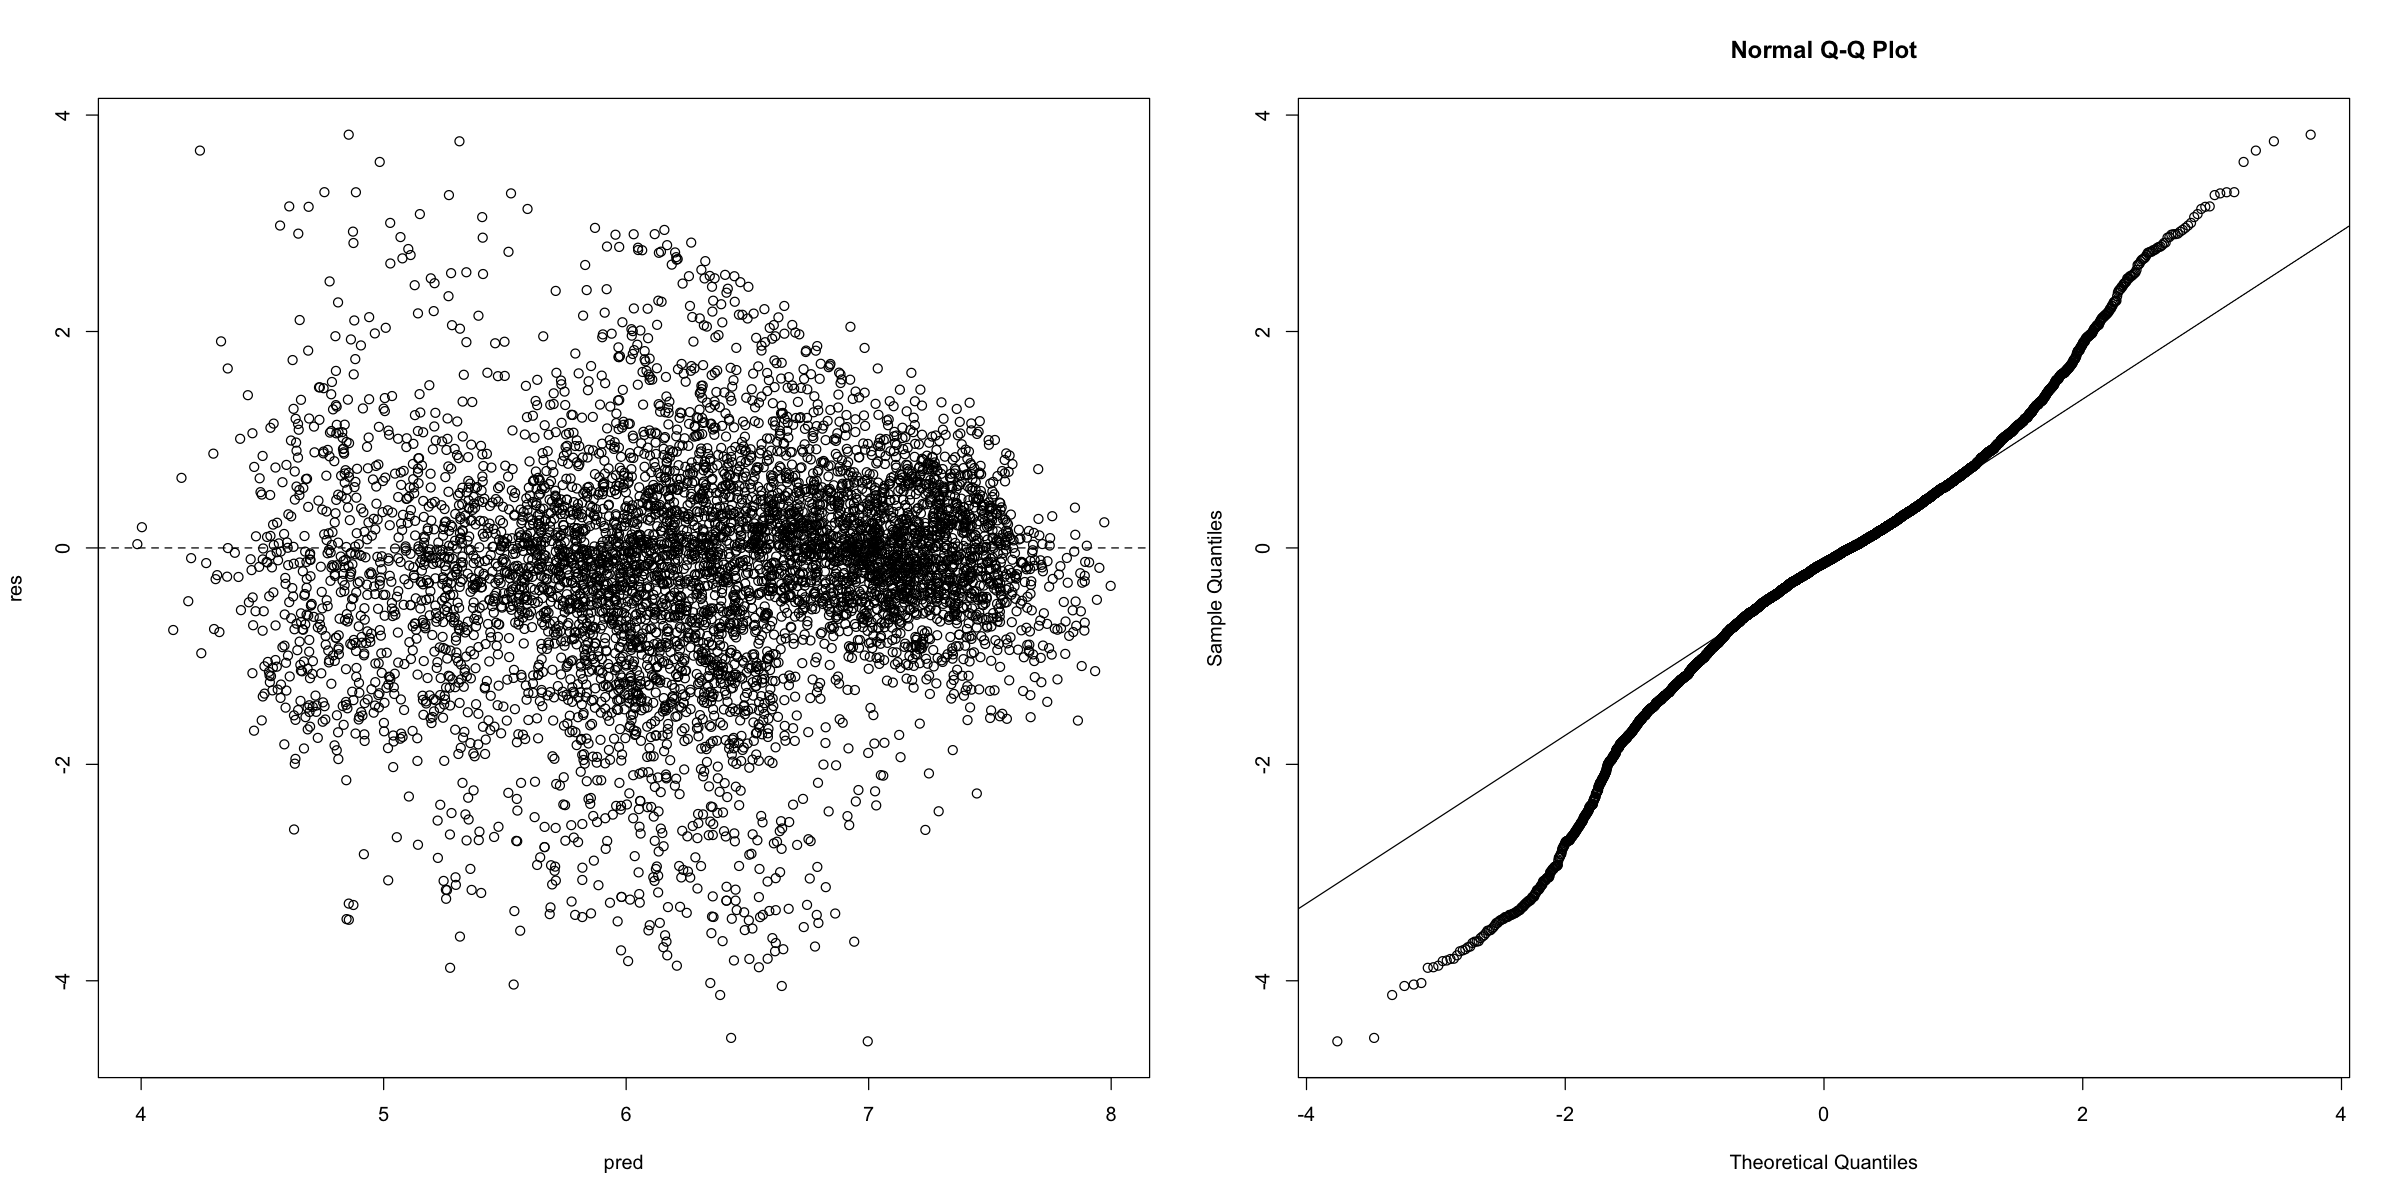

In [21]:
options(repr.plot.width=20, repr.plot.height=10)
par(mfrow=c(1,2))
res <- residuals(AIC_nbinomial_model,type = "deviance")
pred <- predict(AIC_nbinomial_model,type = "link")
plot(y = res, x = pred)
abline(h=0, lty=2)
qqnorm(res)
qqline(res)

In [22]:
#n_sim <- 250
#simulationOutput <- simulateResiduals(fittedModel = AIC_nbinomial_model, n = n_sim)
#plot(simulationOutput, asFactor = F)

##### Compare full model and reduced model

In [23]:
t <- as.data.frame(rbind(glance(nbinomial_model),glance(AIC_nbinomial_model)))
rownames(t) <- c("nbinomial","AIC_nbinomial")
t  %>% dplyr::select(-c(df.residual,nobs,df.null))  %>% 
        mutate(n_coef = c(length(coef(nbinomial_model)),length(coef(AIC_nbinomial_model)))) #%>% 
        #mutate(overdispersion = c(nbinomial_model$theta,AIC_nbinomial_model$theta)) #%>% 
       # mutate(gof.pvalue = c(1 - pchisq(nbinomial_model$deviance, nbinomial_model$df.residual),
       #                      1 - pchisq(AIC_nbinomial_model$deviance, AIC_nbinomial_model$df.residual)))

,null.deviance,logLik,AIC,BIC,deviance,n_coef
,<dbl>,<logLik>,<dbl>,<dbl>,<dbl>,<int>
nbinomial,14169.94,-42340.31,84722.63,84863.06,6355.149,23
AIC_nbinomial,14151.01,-42344.77,84727.54,84854.59,6355.613,18


In [24]:
anova(nbinomial_model,AIC_nbinomial_model)

Model,theta,Resid. df,2 x log-lik.,Test,df,LR stat.,Pr(Chi)
<chr>,<dbl>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>
hour + temp + humidity + solar + snow + holiday + month,2.381945,5907,-84689.54,,NA,NA,NA
hour + temp + humidity + windspeed + visibility + solar + snow + seasons + holiday + month,2.385162,5905,-84680.63,1 vs 2,2,8.912292,0.01160701


There are only 18 coefficients in the reduced model. Overdispersion parameter in the reduced model is slightly lower than that in the full model, which implies larger dispersion with respect to Poisson regression. P-value of likelihood ratio test between full model and reduced model is smaller than 0.05, which indicates that the reduced model selected by AIC is significantly better than the full model under 5% significance level.

Since reduced negative binomial model has lower value of AIC comparing with poisson model, we will apply reduced negative binomial model to predict testing data and evaluate the prediction performance in the next section.

### 2.3 Model Evaluation

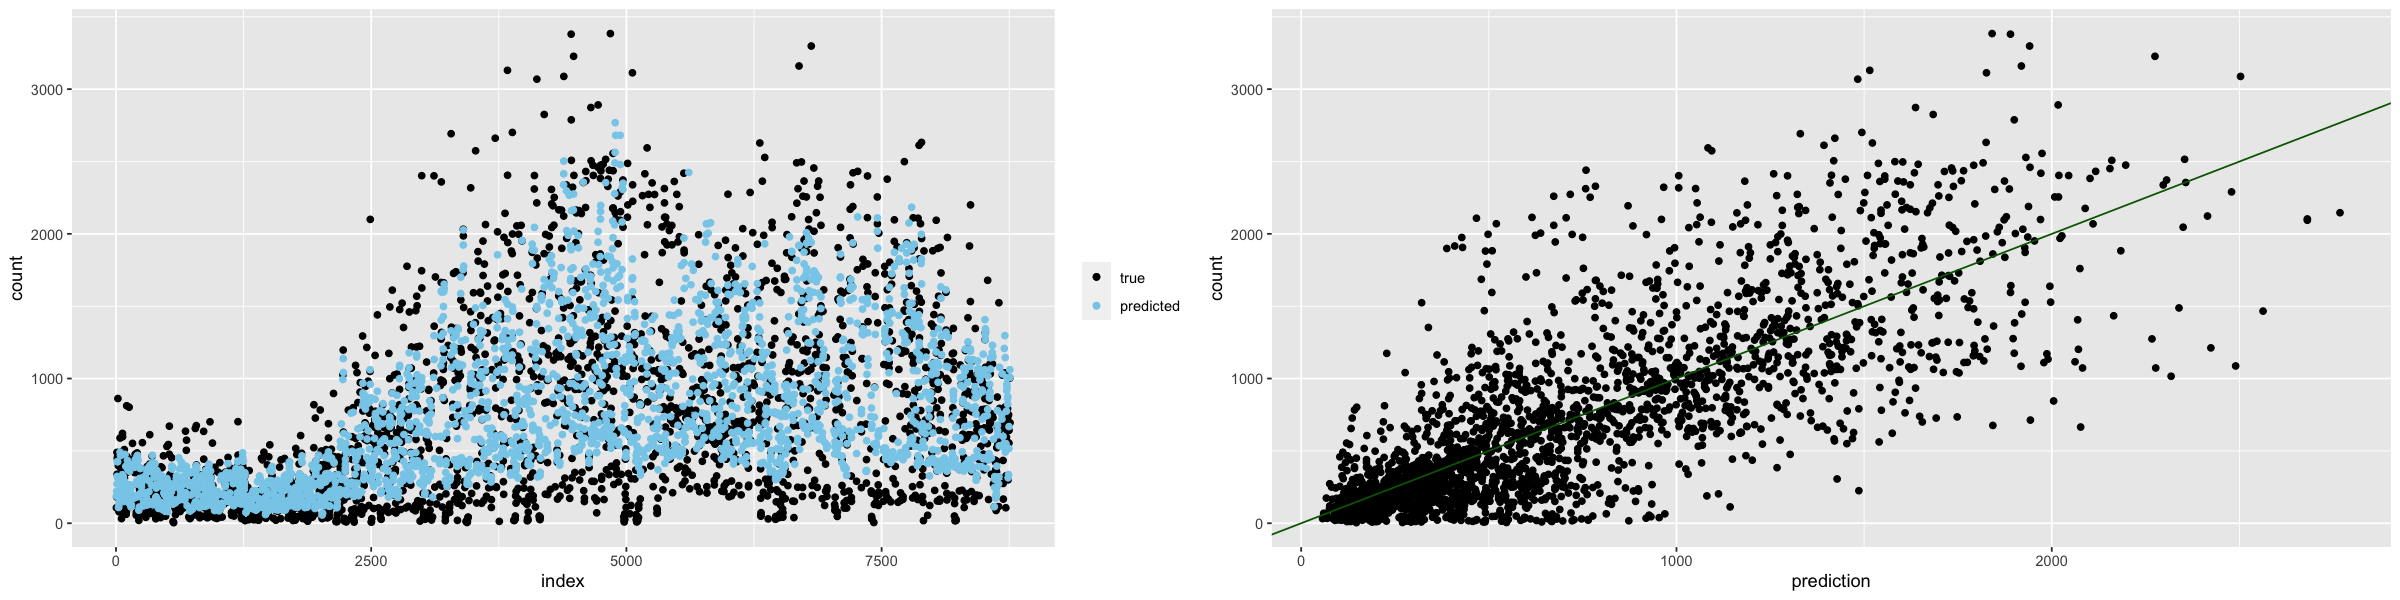

In [25]:
# plot predicted values and actual values
bike_testing$index <- as.numeric(row.names(bike_testing))
bike_testing$pred <- predict(AIC_nbinomial_model,newdata = bike_testing, type = 'response' )
options(repr.plot.width=20, repr.plot.height=5)
g1 <- bike_testing  %>% ggplot(aes(x = index,y = count,color = "true"))  + 
                    geom_point() + 
                    geom_point(aes(y = round(pred,0), x = index,color = "predicted"))+
                    scale_colour_manual("", 
                              breaks = c("true", "predicted"),
                              values = c("black", "sky blue"))
g2 <- bike_testing  %>% ggplot(aes(x = round(pred,0),y = count))  + 
                    geom_point() +
                    xlab("prediction") +
                    geom_abline(intercept = 0, slope = 1, col = "dark green")
ggarrange(g1, g2,
          ncol = 2, nrow = 1)

The variance of count of rental bikes in dataset is mostly explained by predicted values. In the predicted v.s actual value plot, the points are located around the line of y=x, which implies that our model fits the test data well.

In [26]:
# Calculate RMSE
rmse <- Metrics::rmse(actual = bike_testing$count,
              predicted = bike_testing$pred)
# Calculate MAE
mae <- Metrics::mae(actual = bike_testing$count,
              predicted = bike_testing$pred)
#
tibble(RMSE = rmse, MAE = mae)

RMSE,MAE
<dbl>,<dbl>
396.3372,272.7756


## 3. Discussion

### Model Interpretation

The Negative Binomial regression model is given by:

$$Y_i|\mathbf{X}_i \sim \text{NB}(\lambda_i,\theta),$$

$$\log(\lambda_i) = \beta_0 + \beta_1X_{1,i} + \ldots + \beta_pX_{1,p}$$

Consider an observation with a given value $X_{1} = a$, and another observation with 1 unit increasing, $X_{1} = a+1$. Then we have their corresponding regression equations:


$$\log(\lambda_{X_1}) = \beta_0 + \beta_1 a + \ldots + \beta_pX_{1,p}$$

$$\log(\lambda_{X_1+1}) = \beta_0 + \beta_1 (a+1) + \ldots + \beta_pX_{1,p}$$

We take the difference between both equations as:

\begin{align*}
\log(\lambda_{X_1+1}) - \log(\lambda_{X_1}) &= \beta_1 (a + 1) - \beta_1 a \\
&= \beta_1.
\end{align*}

Then, we apply the logarithm property for a ratio:

\begin{align*}
\log \frac{\lambda_{X_1+1}}{\lambda_{X_1}} &= \beta_1.
\end{align*}

Finally, we have to exponentiate the previous equation:

$$
\frac{\lambda_{X_1+1}}{\lambda_{X_1}} = e^{\beta_1}.
$$

The expression $\frac{\lambda_{X_1+1}}{\lambda_{X_1}} = e^{\beta_1}$ indicates that the mean count varies in a multiplicative way when a continuous covariate increases by 1 unit.

Similarly, for categorical variables, $\frac{\lambda_{X_{level1}}}{\lambda_{X_{base}}} = e^{\beta_1}$, which indicates that the mean count varies in a multiplicative way between a specific group and the baseline group.

In [27]:
tidy(AIC_nbinomial_model,exponentiate = TRUE)[c(3,10),]

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
temp,1.040902,0.002072121,19.346052,2.200672e-83
monthDecember,1.286165,0.041676003,6.038609,1.554484e-09


For example:
* For `temp`: The mean count of rental bikes increases by  4.1%  when increasing the temperature by 1 Celsius Degree, while keeping the other covariates constant.
* For `monthDecember`: The mean count of rental bikes is 28.6% higher in December compared to January, while keeping the other covariates constant.

## 4. References